In [16]:
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import re

import metrics

import sys
sys.path.append("../")
from utils import get_all_cot_steps

ROOT = "/sailhome/esui/cs224u_final_project"

FileNotFoundError: [Errno 2] No such file or directory: 'evaluate/bad_patterns.txt'

In [13]:
def get_simple_eval_metrics(path):
    with open(path, 'rb') as f:
        output_df = pickle.load(f)

    output_df['label_acc'] = output_df.apply(lambda x: metrics.strict_acc(x['predicted_answer'], x['gold_answer']), axis=1)
    output_df['cot_acc'] = output_df.apply(lambda x: metrics.strict_acc(x['predicted_cot'], x['gold_cot']), axis=1)
    output_df['cot_precision'] = output_df.apply(lambda x: metrics.cot_precision(get_all_cot_steps([x['predicted_cot']]), get_all_cot_steps([x['gold_cot']])), axis=1)
    output_df['cot_recall'] = output_df.apply(lambda x: metrics.cot_recall(get_all_cot_steps([x['predicted_cot']]), get_all_cot_steps([x['gold_cot']])), axis=1)
    output_df['cot_f1'] = output_df.apply(lambda x: metrics.f1_score(x['cot_precision'], x['cot_recall']), axis=1)

    avg_acc = output_df['label_acc'].values.mean()
    average_cot_acc = output_df['cot_acc'].values.mean()
    avg_cot_precision = output_df['cot_precision'].values.mean()
    avg_cot_recall = output_df['cot_recall'].values.mean()
    avg_cot_f1 = output_df['cot_f1'].values.mean()

    # print(f"Average Label Acc: {avg_acc}")
    # print(f"Average CoT Acc: {average_cot_acc}")
    # print(f"Average CoT Precision: {avg_cot_precision}")
    # print(f"Average CoT Recall: {avg_cot_recall}")
    # print(f"Average CoT F1: {avg_cot_f1}")

    return {
        "avg_label_acc": avg_acc,
        "avg_cot_acc": average_cot_acc,
        "avg_cot_precision": avg_cot_precision,
        "avg_cot_recall": avg_cot_recall,
        "avg_cot_f1": avg_cot_f1
    }

In [4]:
path = f'{ROOT}/prontoqa_output/fictional/aggregated/*'

def get_metrics_dict_for_path_selection_type(path_selection):
    metrics_dict = {} # {aggregation_type: {merge_cot_type: metrics_dict} }
    aggregation_types = []
    merge_cot_types = []
    for p in glob(path):
        # print(p)
        dir, aggregation_type = os.path.split(p)
        path_glob = p + f"/merge_answer_hard_*_path_select_{path_selection}.pkl"

        paths = [p for p in glob(path_glob)]

        if len(paths) > 0:
            aggregation_types.append(aggregation_type)
            metrics_dict[aggregation_type] = {}

            for filename in glob(path_glob):
                merge_cot_type = re.findall(r'merge_cot_(.*)_path', filename)[0]
                if merge_cot_type == 'none' and path_selection != "heaviest":
                    continue
                
                if merge_cot_type not in merge_cot_types:
                    merge_cot_types.append(merge_cot_type)
                
                # print(merge_cot_type)

                metrics_dict[aggregation_type][merge_cot_type] = get_simple_eval_metrics(filename)
    return metrics_dict, aggregation_types, merge_cot_types


In [5]:
def get_data_for_metric(metric, metrics_dict, aggregation_types, merge_cot_types):
    data = []
    for aggregation_type in aggregation_types:
        data_aggregation = [aggregation_type]
        for merge_cot_type in merge_cot_types:
            data_aggregation.append(metrics_dict[aggregation_type][merge_cot_type][metric])
        
        data.append(data_aggregation)
    return data

def get_best_val_per_merge_type(data_df, merge_cot_types):
    print('='*80)
    metrics = {}
    for column in merge_cot_types:
        metrics[column] = data_df[column].values.max()
    
    # print in sorted order
    metrics = sorted(metrics.items(), key=lambda x:x[1], reverse=True)
    for k, v in metrics:
        print(f"{k} max: {v}")

def get_best_val_per_aggregation_type(data_df, aggregation_types):
    print('='*80)
    metrics = {}
    for aggregation_type in aggregation_types:
        max_val = data_df[data_df['Aggregation Type'] == aggregation_type][merge_cot_types].values.max()
        metrics[aggregation_type] = max_val
    
    # print in sorted order
    metrics = sorted(metrics.items(), key=lambda x:x[1], reverse=True)
    for k, v in metrics:
        print(f"{k} max: {v}")

def plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types):
    data = get_data_for_metric(metric, metrics_dict, aggregation_types, merge_cot_types)
    # print(data)
    metrics_df = pd.DataFrame(
            columns=columns,
            data=data
    )

    get_best_val_per_merge_type(metrics_df, merge_cot_types)
    get_best_val_per_aggregation_type(metrics_df, aggregation_types)

    # plot grouped bar chart
    metrics_df.plot(x='Aggregation Type',
            kind='bar',
            stacked=False,
            title=metric
    )

intersection max: 0.9233333333333333
union max: 0.9233333333333333
longest max: 0.9233333333333333
majority max: 0.9233333333333333
baseline max: 0.9233333333333333
direction max: 0.91
forward_negation max: 0.8833333333333333
all max: 0.86
forward_randomized_order max: 0.8466666666666667
forward_all max: 0.8466666666666667
backward_negation max: 0.8133333333333334
backward_all max: 0.72
backward_randomized_order max: 0.6766666666666666


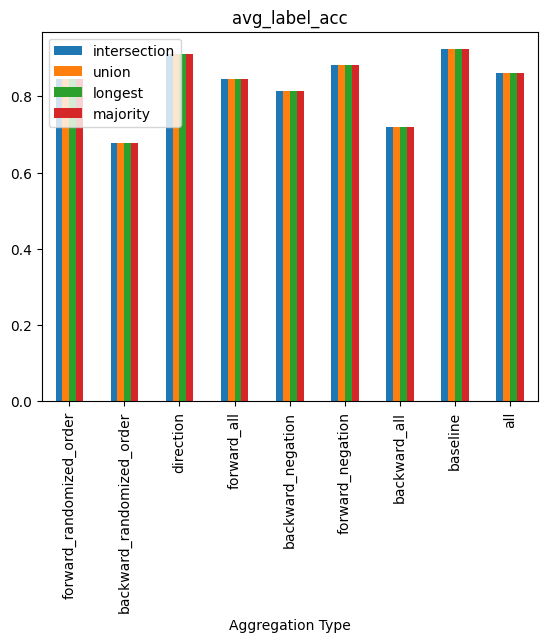

In [7]:
path_selection = "longest"
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(path_selection)
columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_label_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

union max: 0.35333333333333333
majority max: 0.3433333333333333
longest max: 0.33666666666666667
intersection max: 0.24666666666666667
baseline max: 0.35333333333333333
forward_negation max: 0.3433333333333333
backward_negation max: 0.32
forward_all max: 0.31666666666666665
direction max: 0.31333333333333335
forward_randomized_order max: 0.2833333333333333
all max: 0.27666666666666667
backward_all max: 0.21666666666666667
backward_randomized_order max: 0.13333333333333333


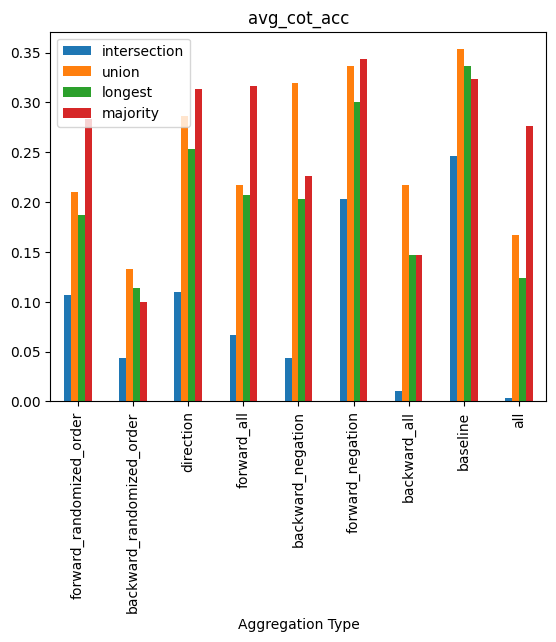

In [8]:
metric = "avg_cot_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.9233333333333333
baseline max: 0.9233333333333333
all max: 0.85
forward_randomized_order max: 0.8466666666666667
direction max: 0.7966666666666666
forward_all max: 0.7966666666666666
backward_randomized_order max: 0.6766666666666666
backward_all max: 0.63
forward_negation max: 0.52
backward_negation max: 0.49333333333333335


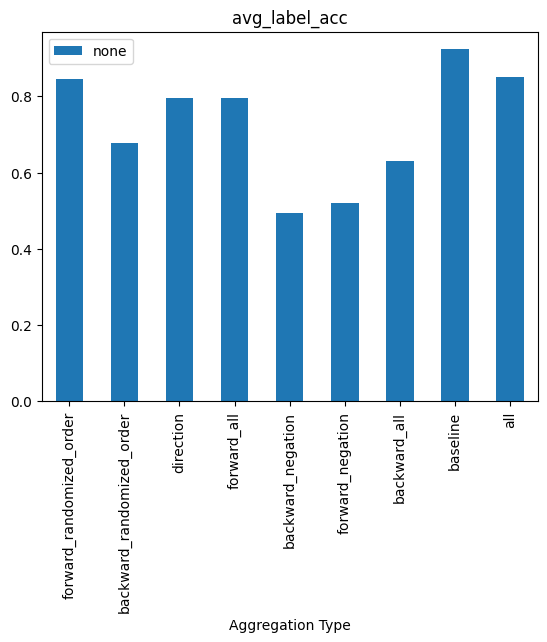

In [52]:
path_selection = "heaviest"
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(path_selection)

columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_label_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.37666666666666665
forward_negation max: 0.37666666666666665
baseline max: 0.36333333333333334
direction max: 0.3
forward_all max: 0.2866666666666667
all max: 0.28
backward_negation max: 0.25
forward_randomized_order max: 0.24333333333333335
backward_all max: 0.20666666666666667
backward_randomized_order max: 0.14666666666666667


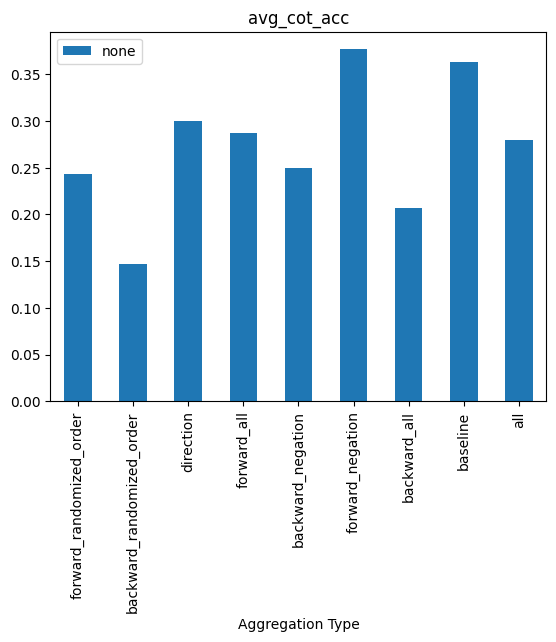

In [53]:
metric = "avg_cot_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.7984448391162787
baseline max: 0.7984448391162787
forward_negation max: 0.7967036220716561
backward_negation max: 0.7520378464128464
direction max: 0.7508943202623544
forward_all max: 0.6891987565238339
forward_randomized_order max: 0.6805710766987857
backward_all max: 0.6708804529234096
backward_randomized_order max: 0.6649479333732429
all max: 0.6608433568065921


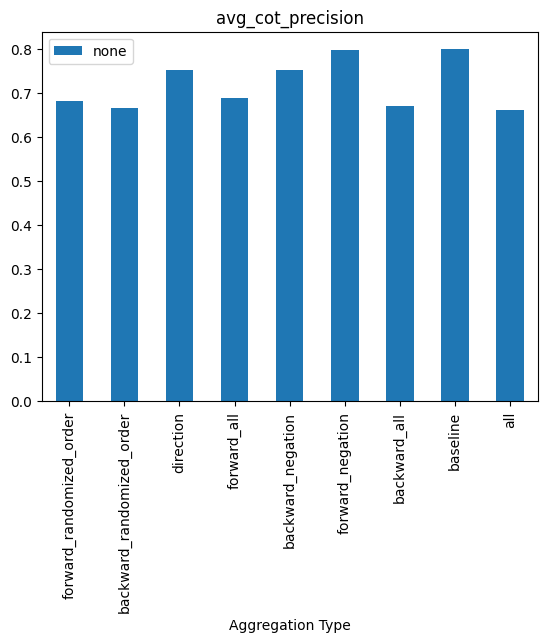

In [54]:
metric = "avg_cot_precision"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.8194805194805196
forward_negation max: 0.8194805194805196
baseline max: 0.8158008658008657
forward_all max: 0.7743290043290043
forward_randomized_order max: 0.7607359307359307
direction max: 0.7583116883116884
all max: 0.7385137085137086
backward_negation max: 0.687056277056277
backward_all max: 0.6696536796536796
backward_randomized_order max: 0.6294372294372295


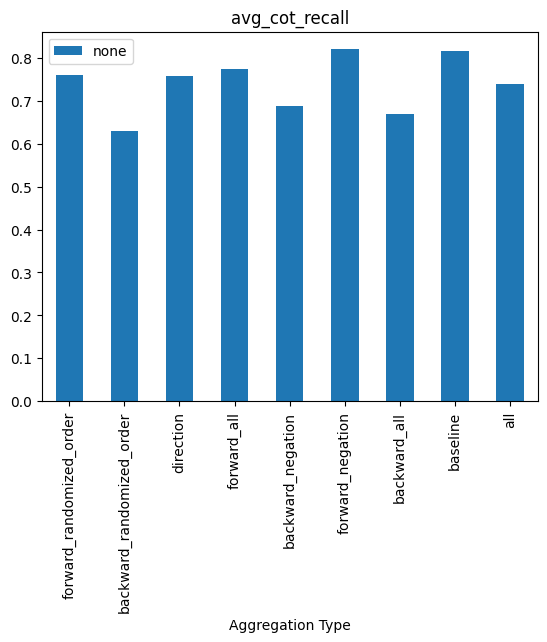

In [55]:
metric = "avg_cot_recall"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.8025447367669372
forward_negation max: 0.8025447367669372
baseline max: 0.8014804450141395
direction max: 0.7466623496475193
forward_all max: 0.7186643430550058
backward_negation max: 0.7074229702597425
forward_randomized_order max: 0.7067973245857142
all max: 0.6844357283497144
backward_all max: 0.6558889995110203
backward_randomized_order max: 0.6302267067646006


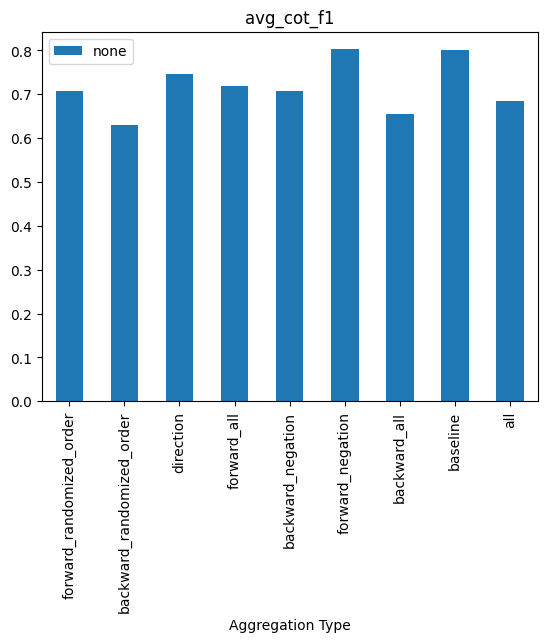

In [56]:
metric = "avg_cot_f1"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

intersection max: 0.8651671677995206
majority max: 0.7717883055054108
longest max: 0.7269195808921041
union max: 0.7033764761153514
baseline max: 0.8651671677995206


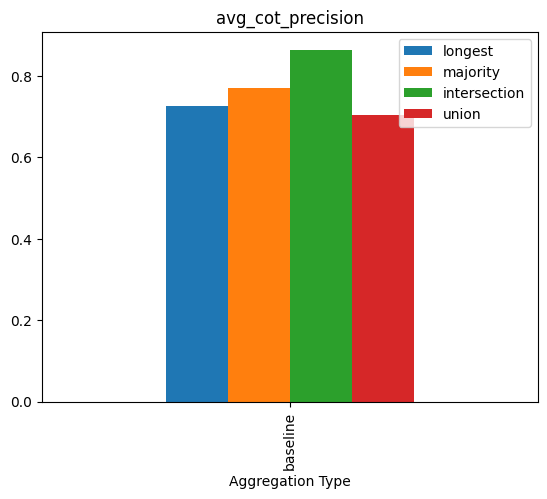

In [10]:
path_selection = "none"
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(path_selection)
columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_cot_precision"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

## Individual eval

In [25]:
FILES = {
        'forward_0': 'forward_1_shot_temp_0.0_seed_1234.pkl',
        'forward_1': 'forward_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'forward_2': 'forward_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'backward_0': 'backward_1_shot_temp_0.0_seed_1234.pkl',
        'backward_1': 'backward_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'backward_2': 'backward_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'forward_neg': 'forward_negated_1_shot_temp_0.0_seed_1234.pkl',
        'backward_neg': 'backward_negated_1_shot_temp_0.0_seed_1234.pkl',
        'baseline_seed1234': 'baseline_1_shot_temp_0.7_seed_1234.pkl',
        'baseline_seed5678': 'baseline_1_shot_temp_0.7_seed_5678.pkl',
        'baseline_seed910': 'baseline_1_shot_temp_0.7_seed_910.pkl',
    }

OUTPUT_ROOT = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional"

def get_metrics_dict_for_prompt_type(prompt_type):
    if prompt_type == "forward":
        path = FILES['forward_0']
    elif prompt_type == "backward":
        path = FILES['backward_0']
    elif prompt_type == "forward_neg":
        path = FILES['forward_neg']
    elif prompt_type == "backward_neg":
        path = FILES['backward_neg']
    elif prompt_type == "baseline":
        path = FILES['baseline_seed1234']
    else:
        raise NotImplementedError(f'prompt_type {prompt_type} not queried')

    path = os.path.join(OUTPUT_ROOT, 'converted', path)

    metrics_dict = get_simple_eval_metrics(path)
    return metrics_dict

def get_data_for_all_metrics(metric, metrics_dict, prompt_types):
    data = []
    for metric in metrics_dict[prompt_types[0]].keys():
        data_metric = [metric]
        for prompt_type in prompt_types:
            data_metric.append(metrics_dict[prompt_type][metric])
        data.append(data_metric)
    return data

              metric   forward  backward  forward_neg  backward_neg  baseline
0      avg_label_acc  0.893333  0.730000     0.886667      0.730000  0.920000
1        avg_cot_acc  0.270000  0.066667     0.300000      0.116667  0.263333
2  avg_cot_precision  0.736858  0.604671     0.759936      0.653389  0.751638
3     avg_cot_recall  0.802597  0.635830     0.822323      0.679076  0.790188
4         avg_cot_f1  0.759750  0.604233     0.781737      0.652136  0.763150


<Axes: title={'center': 'individual eval'}, xlabel='metric'>

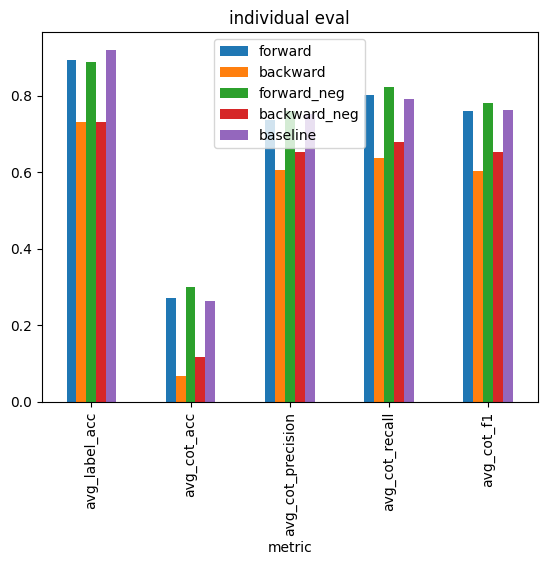

In [26]:
PROMPT_TYPES = ["forward", "backward", "forward_neg", "backward_neg", "baseline"]
columns = ["metric"] + PROMPT_TYPES
metric = "avg_label_acc"
metrics_dict = {}
for prompt_type in PROMPT_TYPES:
    metrics_dict[prompt_type] = get_metrics_dict_for_prompt_type(prompt_type)

data = get_data_for_all_metrics(metric, metrics_dict, PROMPT_TYPES)

metrics_df = pd.DataFrame(
            columns=columns,
            data=data
)

print(metrics_df)

metrics_df.plot(x='metric',
    kind='bar',
    stacked=False,
    title="individual eval"
)